# Environment setup

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 1920, done.
remote: Counting objects: 100% (1920/1920), done.
remote: Compressing objects: 100% (1675/1675), done.
remote: Total 1920 (delta 442), reused 775 (delta 227), pack-reused 0
Receiving objects: 100% (1920/1920), 51.33 MiB | 20.46 MiB/s, done.
Resolving deltas: 100% (442/442), done.


In [3]:

# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf1/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1550708 sha256=8015373da5026256870d6b4076579a361b63ad335e077007a4db852dc5641668
  Stored in directory: /tmp/pip-ephem-wheel-cache-v8u_pbo0/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


## Import libraries

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import sys
from google.colab.patches import cv2_imshow

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Download model weights

In [5]:
if not pathlib.Path('shoeDetection').exists():
  !git clone --depth 1 https://github.com/ibaiGorordo/shoeDetection.git

Cloning into 'shoeDetection'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


# Model Inference


frozen_inference_graph.pb
label_map.pbtxt
test.jpg
test.jpg


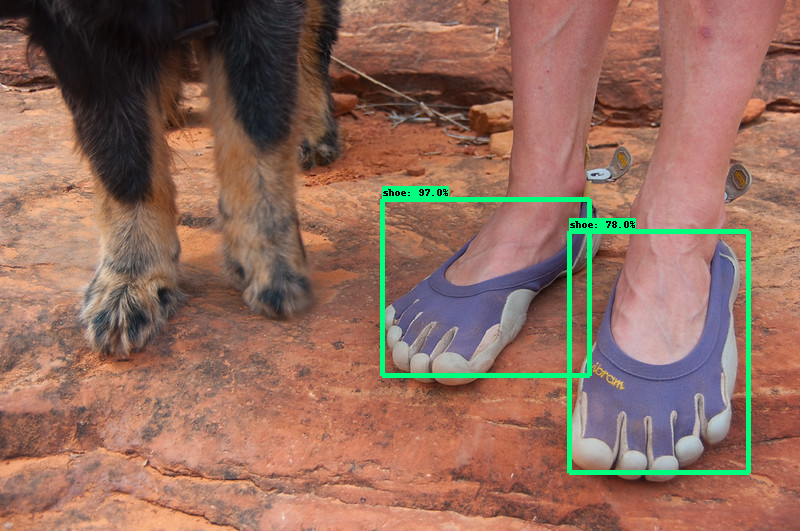

In [6]:
# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = 'shoeDetection/Python inference/frozen_inference_graph.pb'

# Path to label map file
PATH_TO_LABELS = 'shoeDetection/Python inference/label_map.pbtxt'

# Path to image
PATH_TO_IMAGE_FOLDER = 'shoeDetection/Python inference/'

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value

for filename in os.listdir(PATH_TO_IMAGE_FOLDER):
    print(filename)
    if filename.endswith(".jpg"): 
        print(filename)
        image = cv2.imread(os.path.join(PATH_TO_IMAGE_FOLDER, filename))
        image_expanded = np.expand_dims(image, axis=0)

        # Perform the actual detection by running the model with the image as input
        (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],feed_dict={image_tensor: image_expanded})

        # Draw the results of the detection (aka 'visulaize the results')

        vis_util.visualize_boxes_and_labels_on_image_array(
            image,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=5,
            min_score_thresh=0.50)

        # All the results have been drawn on image. Now display the image.
        cv2_imshow(image)